# 머신러닝 프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 3: 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [8]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [10]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [12]:
# 한글 표시를 위한 라이브러리 설치
# !pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [14]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기



# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [16]:
# 파일 읽어오기
data = joblib.load(path+'base_data2.pkl')

# 확인
data.head()

,총세대수,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료
0,78,2013,계단식,개별,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,35,2013,복도식,개별,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,88,2013,계단식,개별,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,477,2014,복도식,지역,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,15,2013,복도식,개별,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333


### (6) 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [18]:
# 실젯값, 예측값 비교 함수 만들기
def model_plot(y_test, y_pred):
    plt.figure(figsize=(10, 3))
    plt.plot(y_test.values, label='Actual', linewidth=0.7, marker='o', markersize=2)
    plt.plot(y_pred, label='Predicted', linewidth=0.7, marker='o', markersize=2)
    plt.legend()
    plt.show()

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [22]:
dumm_cols = ['건물형태','난방방식']

data = pd.get_dummies(data, columns = dumm_cols, drop_first=True, dtype=int)
data.head()

,총세대수,준공연도,승강기설치여부,실차량수,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,78,2013,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000,0,0,0,0
1,35,2013,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000,1,0,0,0
2,88,2013,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000,0,0,0,0
3,477,2014,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000,1,0,0,1
4,15,2013,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333,1,0,0,0


#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [24]:
target = '실차량수'
x = data.drop(columns=target)
y = data[target]

#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

In [28]:
from sklearn.preprocessing import MinMaxScaler

# 정규화
x_cols = list(x_train)
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [29]:
# 회귀 문제
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor   # 앙상블
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

In [30]:
# 성능비교하기
result = {}

### (1) 모델 1: Linear Regression

In [32]:
# 선언하기
model_LR = LinearRegression()

# 학습하기
model_LR.fit(x_train,y_train)

# 예측하기
y_pred_LR = model_LR.predict(x_test)

# 검증하기
print('MAE: ', mean_absolute_error(y_test,y_pred_LR).round(4))
print('R2: ', r2_score(y_test,y_pred_LR).round(4))

result['Linear Regression'] = r2_score(y_test,y_pred_LR).round(4)

MAE:  149.341
R2:  0.6553


In [33]:
result

{'Linear Regression': 0.6553}

### (2) 모델 2: KNN

In [35]:
# 파라미터 선언
param = {'n_neighbors': range(1, 21)}

model_KNN = GridSearchCV(KNeighborsRegressor(),
                         param,
                           cv = 5,                   # K 분할 개수
                            scoring = 'r2')          # 사용할 평가 지표

# 학습하기(많은 시간이 소요될 수 있음)
model_KNN.fit(x_train_s,y_train)

# 최적 파라미터, 예측 최고 성능
print('최적파라미터:', model_KNN.best_params_)
print('최고성능:', model_KNN.best_score_)

# 예측하기
y_pred_KNN = model_KNN.predict(x_test_s)

# 검증하기
print('MAE: ', mean_absolute_error(y_test,y_pred_KNN).round(4))
print('R2: ', r2_score(y_test,y_pred_KNN).round(4))

result['KNN'] = r2_score(y_test,y_pred_KNN).round(4)

최적파라미터: {'n_neighbors': 4}
최고성능: 0.6765704194492599
MAE:  164.601
R2:  0.613


In [36]:
result

{'Linear Regression': 0.6553, 'KNN': 0.613}

### (3) 모델 3: DecisionTree

In [38]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}

model_DT = GridSearchCV(DecisionTreeRegressor(random_state=1),
                         param,
                           cv = 5,                   # K 분할 개수
                            scoring = 'r2')          # 사용할 평가 지표

# 학습하기(많은 시간이 소요될 수 있음)
model_DT.fit(x_train,y_train)

# 최적 파라미터, 예측 최고 성능
print('최적파라미터:', model_DT.best_params_)
print('최고성능:', model_DT.best_score_)

# 예측하기
y_pred_DT = model_DT.predict(x_test)

# 검증하기
print('MAE: ', mean_absolute_error(y_test,y_pred_DT).round(4))
print('R2: ', r2_score(y_test,y_pred_DT).round(4))

result['Decision Tree'] = r2_score(y_test,y_pred_DT).round(4)

최적파라미터: {'max_depth': 3}
최고성능: 0.6687860015428747
MAE:  171.232
R2:  0.622


### (4) 모델 4: RandomForest

In [40]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}

model_RF = GridSearchCV(RandomForestRegressor(random_state=1),
                         param,
                           cv = 5,                   # K 분할 개수
                            scoring = 'r2')          # 사용할 평가 지표

# 학습하기(많은 시간이 소요될 수 있음)
model_RF.fit(x_train,y_train)

# 최적 파라미터, 예측 최고 성능
print('최적파라미터:', model_RF.best_params_)
print('최고성능:', model_RF.best_score_)

# 예측하기
y_pred_RF = model_RF.predict(x_test)

# 검증하기
print('MAE: ', mean_absolute_error(y_test,y_pred_RF).round(4))
print('R2: ', r2_score(y_test,y_pred_RF).round(4))

result['RandomForest'] = r2_score(y_test,y_pred_RF).round(4)

최적파라미터: {'max_depth': 5}
최고성능: 0.759085680383351
MAE:  131.4842
R2:  0.7002


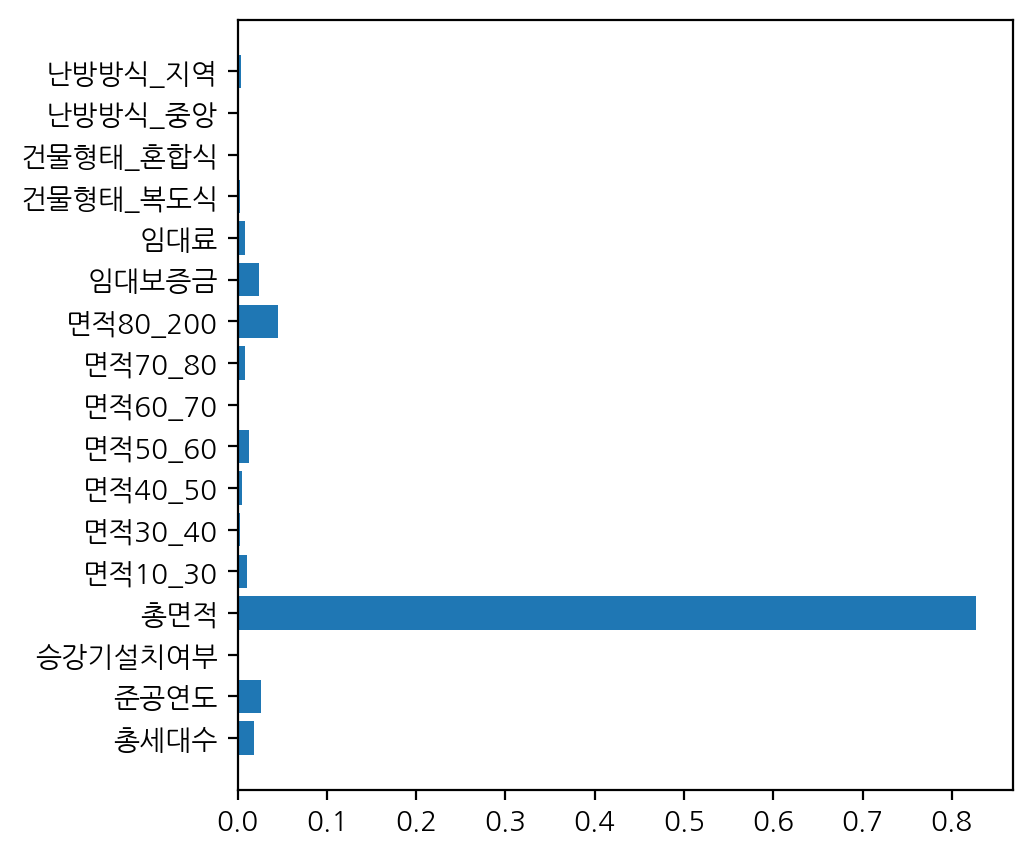

In [41]:
# 변수 중요도 시각화
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model_RF.best_estimator_.feature_importances_)
# best_estimator_ 에서 변수의 중요도를 보여주는거임.
plt.show()

### (5) 모델 5: XGBoost

In [43]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}

model_XGB = GridSearchCV(XGBRegressor(random_state=1),
                         param,
                           cv = 5,                   # K 분할 개수
                            scoring = 'r2')          # 사용할 평가 지표

# 학습하기(많은 시간이 소요될 수 있음)
model_XGB.fit(x_train,y_train)

# 최적 파라미터, 예측 최고 성능
print('최적파라미터:', model_XGB.best_params_)
print('최고성능:', model_XGB.best_score_)

# 예측하기
y_pred_XGB = model_XGB.predict(x_test)

# 검증하기
print('MAE: ', mean_absolute_error(y_test,y_pred_XGB).round(4))
print('R2: ', r2_score(y_test,y_pred_XGB).round(4))

result['XGBoost'] = r2_score(y_test,y_pred_XGB).round(4)

최적파라미터: {'max_depth': 1}
최고성능: 0.7226250969503516
MAE:  134.296
R2:  0.6928


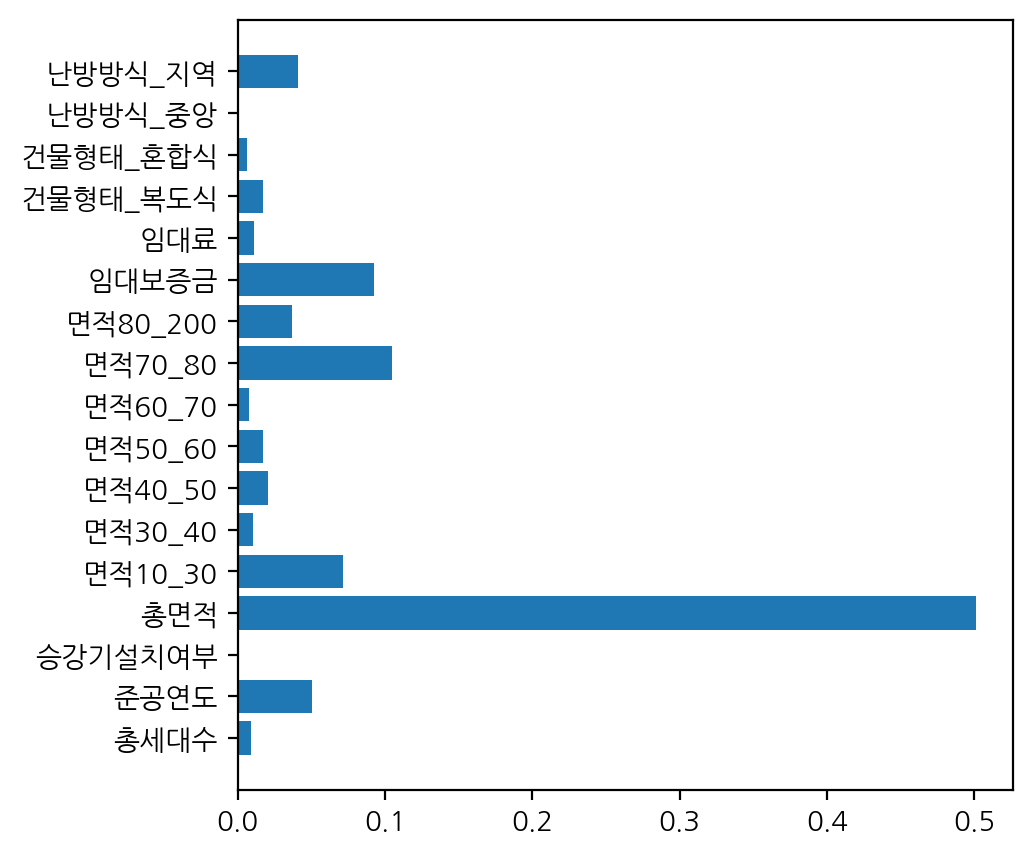

In [44]:
# 변수 중요도 시각화
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model_XGB.best_estimator_.feature_importances_)
plt.show()

### (6) 모델 6: LightGBM

In [46]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}

model_LGB = GridSearchCV(LGBMRegressor(verbose=-1,random_state=1),
                         param,
                           cv = 5,                   # K 분할 개수
                            scoring = 'r2')          # 사용할 평가 지표

# 학습하기(많은 시간이 소요될 수 있음)
model_LGB.fit(x_train,y_train)

# 최적 파라미터, 예측 최고 성능
print('최적파라미터:', model_LGB.best_params_)
print('최고성능:', model_LGB.best_score_)

# 예측하기
y_pred_LGB = model_LGB.predict(x_test)

# 검증하기
print('MAE: ', mean_absolute_error(y_test,y_pred_LGB).round(4))
print('R2: ', r2_score(y_test,y_pred_LGB).round(4))

result['LGBM'] = r2_score(y_test,y_pred_LGB).round(4)

최적파라미터: {'max_depth': 2}
최고성능: 0.7483066441631843
MAE:  137.1995
R2:  0.6715


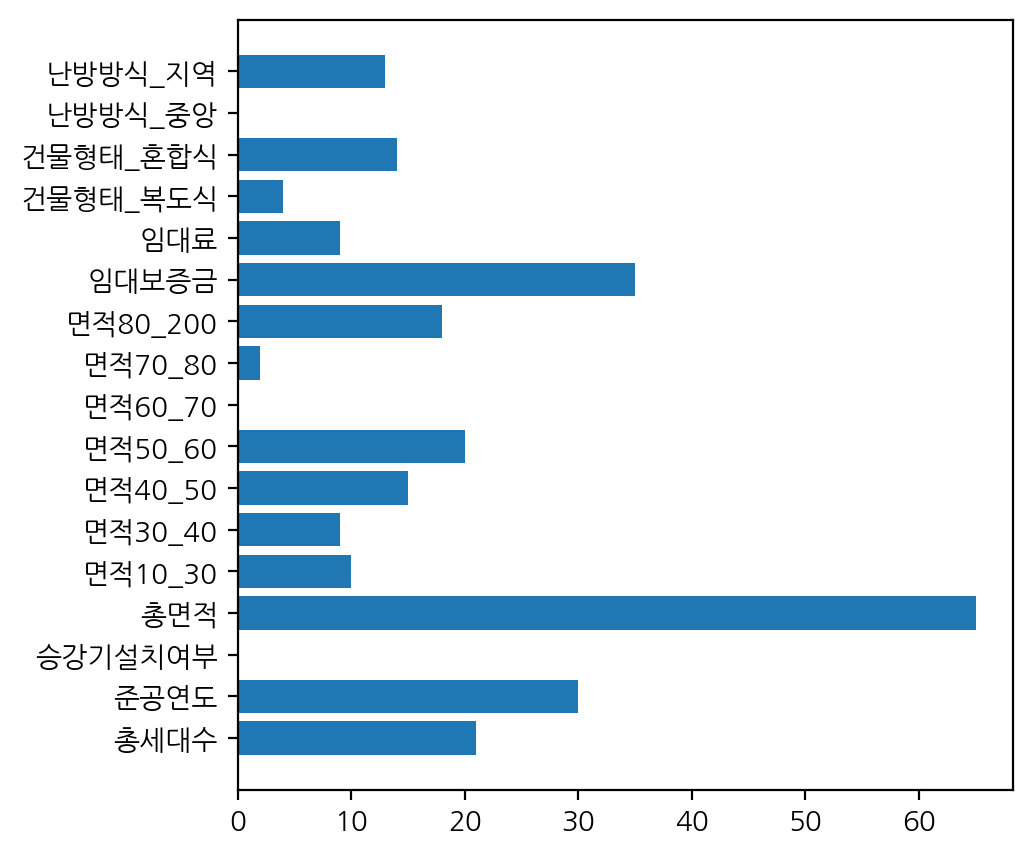

In [47]:
# 변수 중요도 시각화
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model_LGB.best_estimator_.feature_importances_)
plt.show()

### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

In [49]:
result

{'Linear Regression': 0.6553,
 'KNN': 0.613,
 'Decision Tree': 0.622,
 'RandomForest': 0.7002,
 'XGBoost': 0.6928,
 'LGBM': 0.6715}

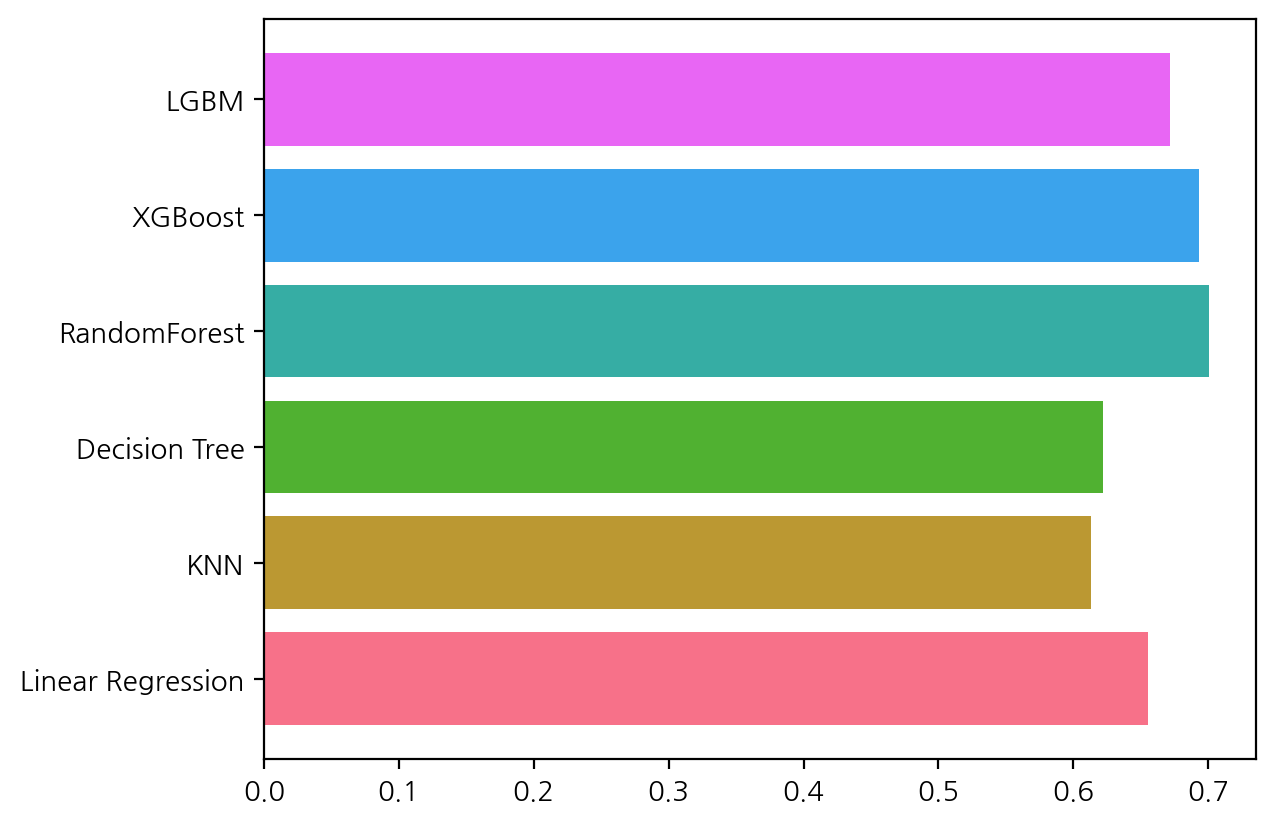

In [50]:
# 성능 시각화 비교
# 색상 팔레트 생성
colors = sns.color_palette("husl", len(result))  # 'husl' 색상 팔레트 사용
plt.barh(list(result), result.values(), color=colors)
plt.show()

## 3. 파이프라인 구축

- 새로운 데이터를 불러오고, 이 데이터를 처리할 파이프라인 함수를 만듭니다.

### (1) New Data 불러오기

- test.xlsx 파일을 읽어와 new_data 데이터프레임으로 선언합니다.
- 해당 데이터는 '실차량수' 변수가 없는 것 외에는, 최초 데이터와 동일한 구조입니다.
- 이 데이터를 대상으로 전처리와 예측을 수행합니다.

In [53]:
# 파일 읽어오기
new_data = pd.read_excel(path+'test.xlsx')

# 확인
new_data

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료
0,C0005,서울석촌 도시형주택(공임10년),20,6,서울,20121115,복도식,개별가스난방,전체동 설치,9,17.53,11.7251,50449000,263710
1,C0005,서울석촌 도시형주택(공임10년),20,10,서울,20121115,복도식,개별가스난방,전체동 설치,9,24.71,16.5275,52743000,321040
2,C0005,서울석촌 도시형주택(공임10년),20,4,서울,20121115,복도식,개별가스난방,전체동 설치,9,26.72,17.8720,53890000,332510
3,C0017,대구혁신센텀힐즈,822,228,대구경북,20180221,계단식,지역난방,NaN,824,51.87,20.9266,29298000,411200
4,C0017,대구혁신센텀힐즈,822,56,대구경북,20180221,계단식,지역난방,NaN,824,59.85,24.1461,38550000,462600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,C0353,대전판암3,768,90,대전충남,19910805,복도식,중앙난방,전체동 설치,142,40.32,16.5100,8848000,122290
100,C0360,하남미사 A26BL,588,98,서울,20160901,NaN,지역난방,NaN,539,51.37,21.5569,183228000,0
101,C0360,하남미사 A26BL,588,186,서울,20160901,NaN,지역난방,NaN,539,51.39,21.5652,183228000,0
102,C0360,하남미사 A26BL,588,102,서울,20160901,NaN,지역난방,NaN,539,59.76,25.0776,215057000,0


### (2) 데이터 파이프라인 구축

- 데이터 파이프라인 함수를 만듭니다.
- 학습 데이터에 대해 진행했던 모든 전처리 과정을 평가 데이터에도 일괄 진행해야 합니다.
    - 입력: new_data
    - 출력: 전처리가 완료된 예측 직전 데이터프레임
- 새로운 데이터에는 '실차량수' 변수가 없음을 유의합니다.
- 참고: 다음 내용들이 처리되어야 합니다.
    - 결측치 처리
    - 변수 추가
    - 불필요한 변수 제거
    - 단지 데이터, 상세 데이터 분리
    - 단지코드별 총면적 합 집계
    - 전용면적 구간별 집계 (피벗 형태)
    - 임대보증금, 임대료 평균 집계
    - 집계 결과 병합
    - 난방방식: 개별, 지역, 중앙 세 가지로 묶기
    - 승강기설치여부: 0, 1 값으로 변경
    - 단지모드, 지역 변수 제거
    - 가변수화

In [55]:
# 파이프라인 만들기
def data_pipeline(data):
    apt01 = data.copy()
    # 결측치처리
    nan_cols = ['건물형태', '난방방식', '승강기설치여부']
    for col in nan_cols:
        apt01[col] = apt01[col].fillna(apt01[col].mode()[0])
    # 변수 추가
    apt01['준공연도'] = apt01['준공일자'].astype(str).str[:4].astype(int)
    apt01['총면적'] = (apt01['전용면적'] + apt01['공용면적']) * apt01['전용면적별세대수']
    
    drop_cols = ['단지명', '단지내주차면수','준공일자']
    apt01.drop(columns=drop_cols, inplace=True)
    
    data01 = apt01[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부']]
    data01 = data01.drop_duplicates()

    # 인덱스 초기화 (기존 인덱스 제거)
    data01.reset_index(drop=True, inplace=True)
    data02 = apt01[['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]

    df_area = data02.groupby('단지코드')['총면적'].sum().reset_index()

    # 2. 전용면적을 의미있는 구간으로 나누어 피벗 형태로 집계
    bins = [10, 30, 40, 50, 60, 70, 80, 200]  # 전용면적 구간
    # labels = ['10 이상 30 미만', '30 이상 40 미만','40 이상 50 미만','50 이상 60 미만','60 이상 70 미만','70 이상 80 미만','80 이상 140 미만']
    labels = ['면적10_30','면적30_40','면적40_50','면적50_60','면적60_70','면적70_80','면적80_200']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=bins,labels=labels)

    temp = data02.groupby(['단지코드', '전용면적구간'])['전용면적별세대수'].sum().reset_index()
    # temp 데이터프레임을 피벗 형태로 변환
    df_pivot = temp.pivot(index='단지코드', columns='전용면적구간', values='전용면적별세대수')
    
    # 인덱스 초기화
    df_pivot.reset_index(inplace=True)
    
    # 열 이름에 대한 이름 제거
    df_pivot.columns.name = None
    
    df_rent = data02.groupby('단지코드')[['임대보증금','임대료']].mean().reset_index()
    
    base_data = pd.merge(data01, df_area, on='단지코드', how='left')
    # base_data와 df_pivot 조인
    base_data = pd.merge(base_data, df_pivot, on='단지코드', how='left')
    # base_data와 df_rent 조인
    base_data = pd.merge(base_data, df_rent, on='단지코드', how='left')

    # 난방방식 값 변경
    base_data['난방방식'] = base_data['난방방식'].replace({
        '개별가스난방': '개별',
        '개별유류난방': '개별',
        '지역난방': '지역',
        '지역가스난방': '지역',
        '지역유류난방': '지역',
        '중앙가스난방': '중앙',
        '중앙난방': '중앙',
        '중앙유류난방': '중앙'
    })
    
    # 난방방식 값 변경
    base_data['승강기설치여부'] = base_data['승강기설치여부'].replace({
        '전체동 설치': 1,
        '일부동 설치': 0,
        '미설치': 0
    })
    
    drop_cols = ['단지코드', '지역']
    base_data.drop(columns=drop_cols, inplace=True)

    # 가변수화
    dumm_cols = ['건물형태','난방방식']

    x = pd.get_dummies(base_data, columns = dumm_cols, drop_first=True, dtype=int)
    # 파일로 저장
    joblib.dump(x, path+'x.pkl')

    # 가변수화 확인 겸 데이터 확인
    return x

### (3) 예측하기

- new_data를 파이프라인을 사용해 전처리한 후 가장 성능이 좋았던 모델로 예측한 결과를 확인합니다.

In [57]:
# 데이터 전처리
data = data_pipeline(new_data)

# 확인
data.head()

,총세대수,준공연도,승강기설치여부,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,20,2012,1,766.2736,20,0,0,0,0,0,0,5.236067e+07,305753.333333,1,0,0,0
1,822,2018,1,31396.0944,0,0,0,404,0,0,0,3.546600e+07,445466.666667,0,0,0,1
2,112,2014,1,12450.4308,0,0,0,0,0,20,92,9.869750e+07,744450.000000,0,0,0,1
3,122,2011,1,13081.4772,0,0,0,0,0,22,100,0.000000e+00,0.000000,0,0,0,1
4,262,2011,1,28141.7516,0,0,0,0,0,77,185,0.000000e+00,0.000000,0,0,0,1


In [58]:
# 예측하기
predicted = model_RF.predict(data)

# 확인
print(predicted)

[ 158.14525584  402.4141378   547.14255803  510.15396275  679.65716906
  399.74661502  427.25059016  688.62890723  460.3627445   348.81013001
  264.66643679  178.17318261 1401.2841445   694.52105626  546.81560212
  683.95238071  616.5361613   196.75911833 1071.37151641 1011.72976135
  299.46993294  827.81131927  843.61863397  840.16205677  882.18650752
  241.7487599   125.39746931 1324.60880756  260.62082653  738.07129279]


- 아파트 기본 정보에 예측한 차량수를 붙여 마무리합니다.

In [60]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역']
result = new_data[vars].copy()
result = result.drop_duplicates()
result.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result['예상차량수'] = predicted.round(1).astype(int)
# 확인
result.head()

,단지코드,단지명,총세대수,지역,예상차량수
0,C0005,서울석촌 도시형주택(공임10년),20,서울,158
1,C0017,대구혁신센텀힐즈,822,대구경북,402
2,C0034,광교 호반마을 22단지 아파트,112,경기,547
3,C0046,죽미마을 휴먼시아12단지,122,경기,510
4,C0055,파주운정 한울마을 6단지,262,경기,679


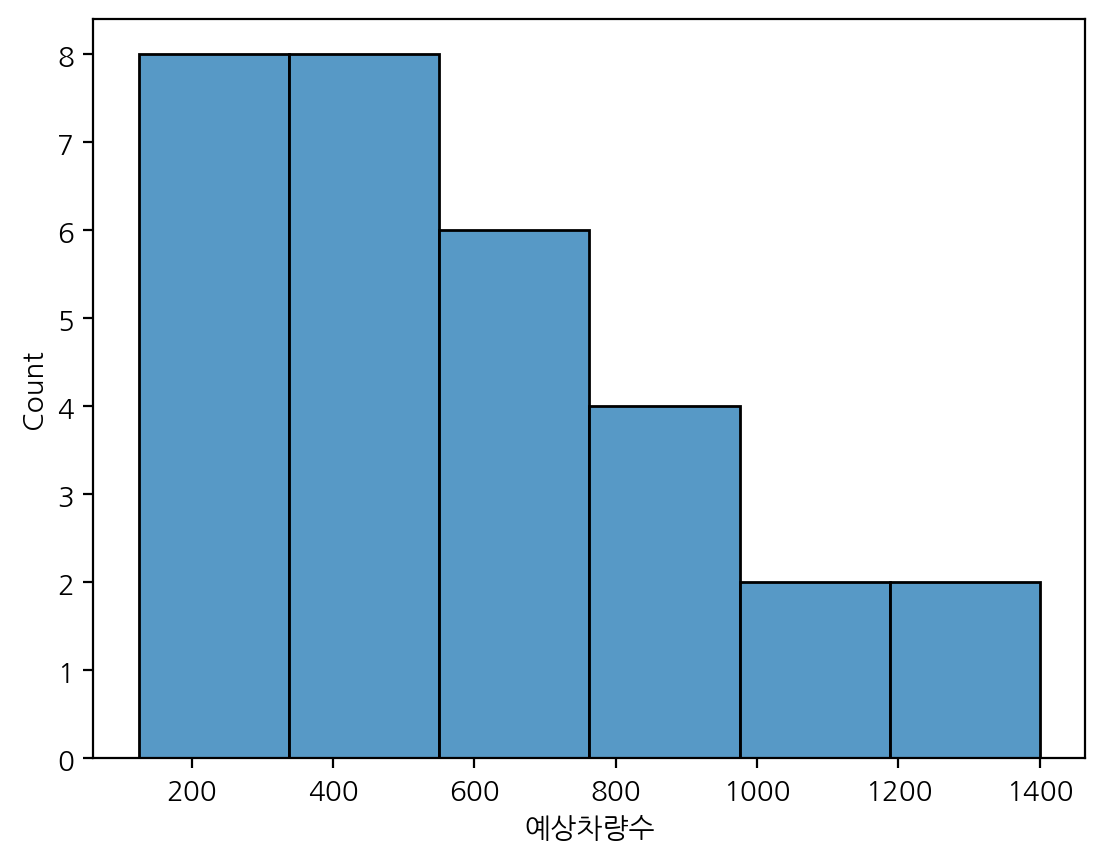

In [475]:
sns.histplot(result['예상차량수'])
plt.show()

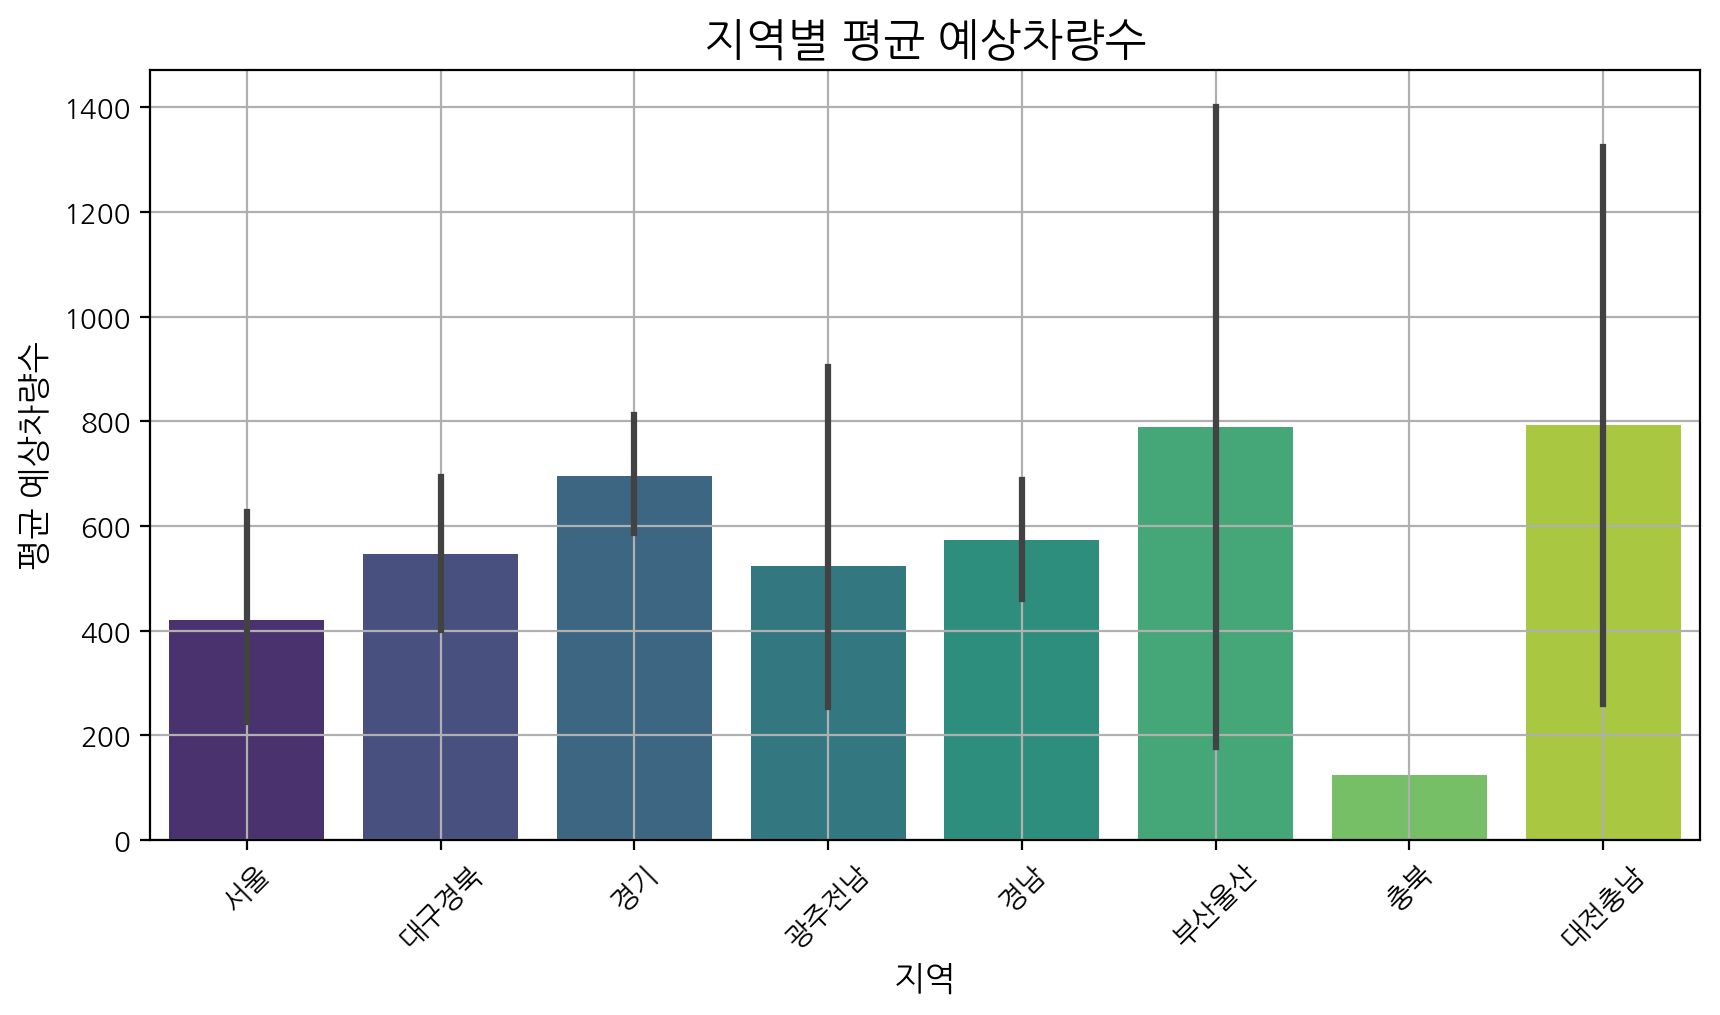

In [81]:
# 지역별 평균 예상차량수 계산
region_vehicle_counts = result.groupby('지역')['예상차량수'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='지역', y='예상차량수', data=result, palette='viridis')
plt.title('지역별 평균 예상차량수', fontsize=16)
plt.xlabel('지역', fontsize=12)
plt.ylabel('평균 예상차량수', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()

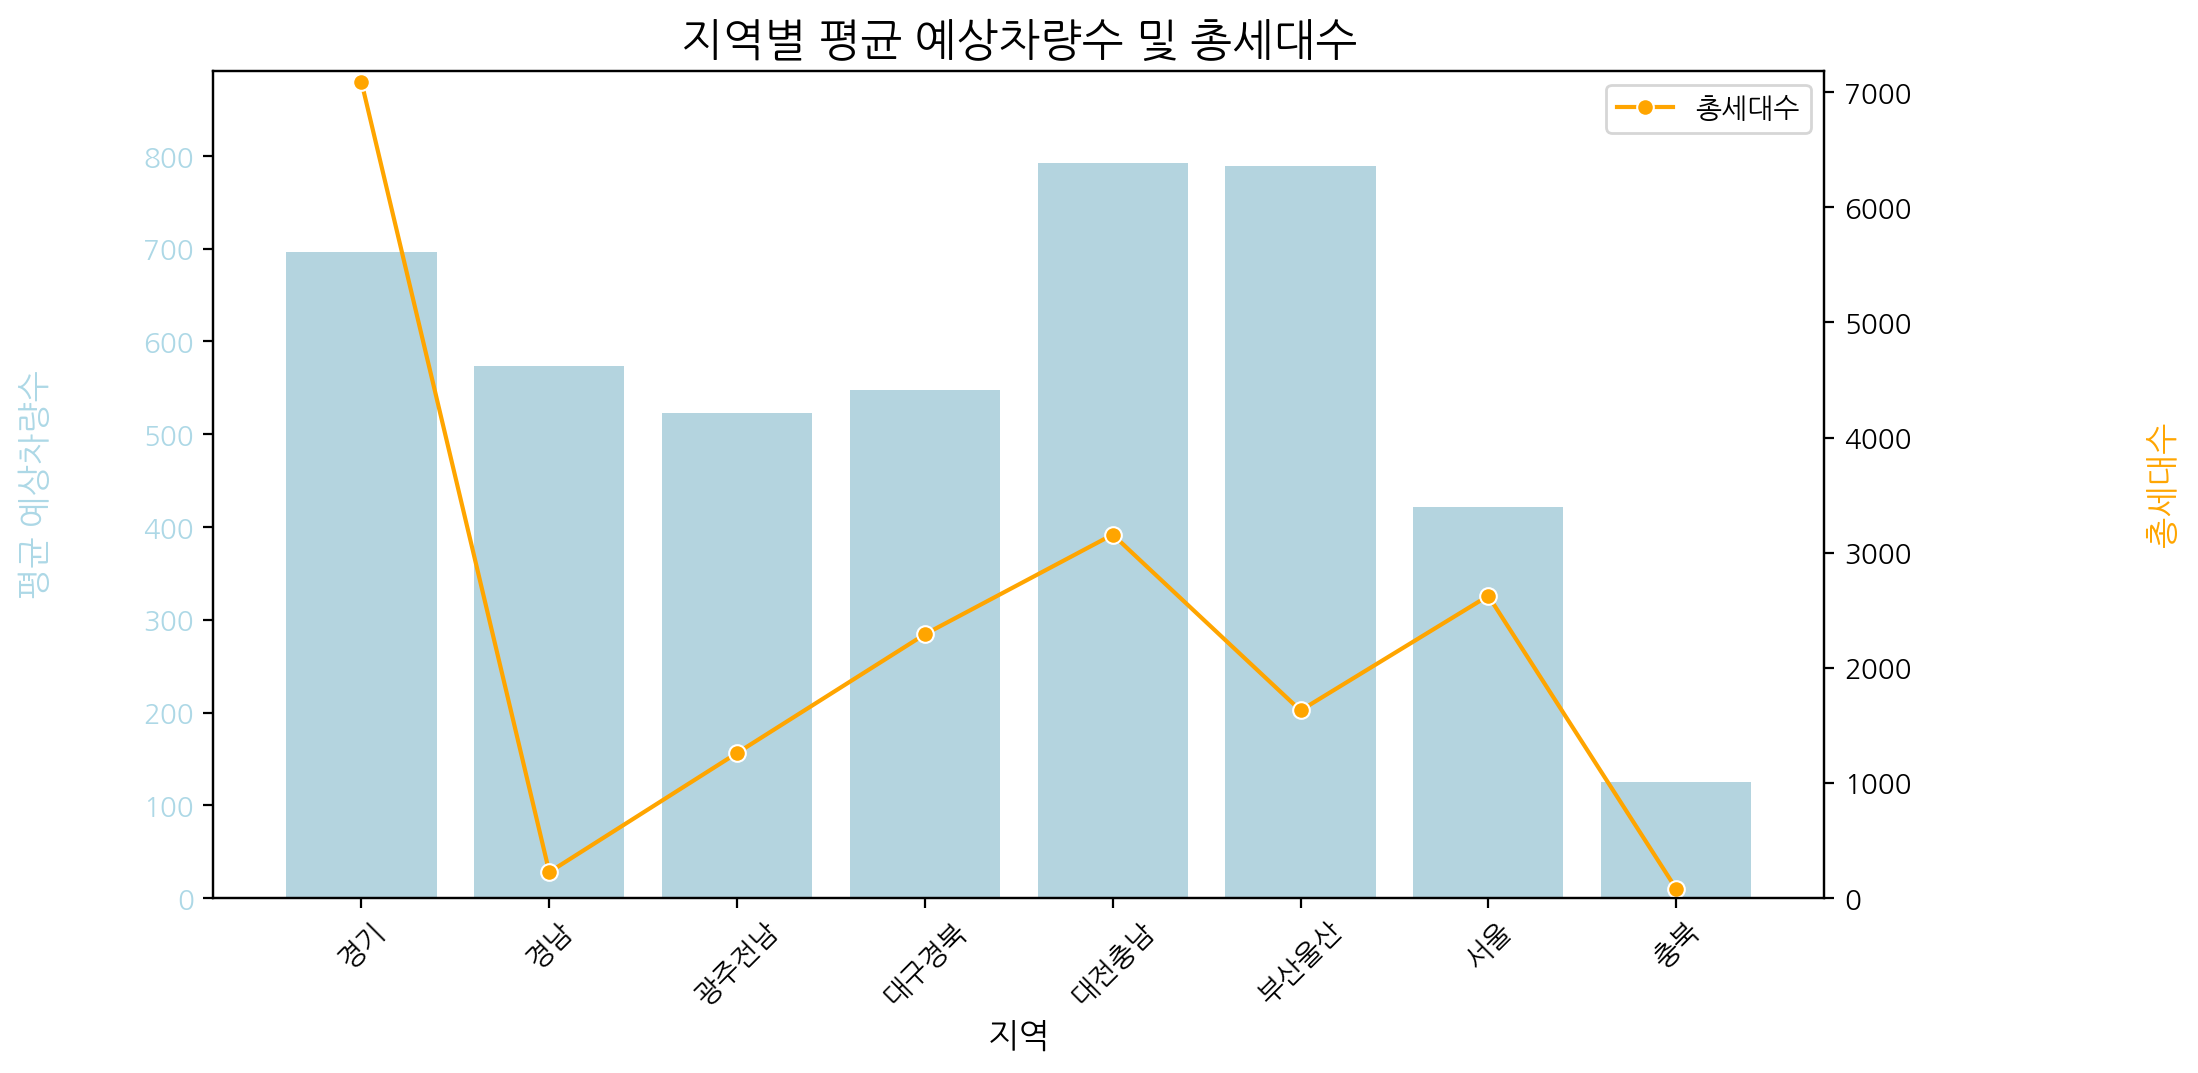

In [82]:
df = pd.DataFrame(result)

# 지역별 평균 예상차량수와 총세대수 계산
region_data = df.groupby('지역').agg({'예상차량수': 'mean', '총세대수': 'sum'}).reset_index()

# 이중 축 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))  # 그래프 크기 조정

# 차량 수를 나타내는 막대 그래프
sns.barplot(x='지역', y='예상차량수', data=region_data, ax=ax1, color='lightblue')
ax1.set_ylabel('평균 예상차량수', fontsize=12, color='lightblue', labelpad=10)
ax1.tick_params(axis='y', labelcolor='lightblue')

# 두 번째 축 생성
ax2 = ax1.twinx()
sns.lineplot(x='지역', y='총세대수', data=region_data, ax=ax2, color='orange', marker='o', label='총세대수')
ax2.set_ylabel('총세대수', fontsize=12, color='orange', labelpad=10)

# y축 위치 조정
ax1.yaxis.set_label_coords(-0.1, 0.5)  # 왼쪽 y축 레이블 위치
ax2.yaxis.set_label_coords(1.2, 0.5)  # 오른쪽 y축 레이블 위치

# y축의 범위 조정
ax1.set_ylim(0, region_data['예상차량수'].max() + 100)  # 왼쪽 y축 범위
ax2.set_ylim(0, region_data['총세대수'].max() + 100)  # 오른쪽 y축 범위

# 제목 및 레이아웃
plt.title('지역별 평균 예상차량수 및 총세대수', fontsize=16)
ax1.set_xlabel('지역', fontsize=12)
ax1.set_xticklabels(region_data['지역'], rotation=45)
fig.tight_layout(pad=3.0)  # 마진 조정
plt.show()